# 2D Spot Detection with Icy

## Discipline: Spot / object counting (SptCnt)¶

Task: Estimate the number of objects

This project illustrates the 2D counting of small vesicle like objects.

## The input images

The images were generated by SIMCEP, a widefield fluorescence microscopy biological images simulator.

First we create the folders needed by the workflow and download the dataset from zenodo.

In [1]:
IN_FOLDER = "/home/jovyan/data/in/"
GT_FOLDER = "/home/jovyan/data/gt/"
OUT_FOLDER = "/home/jovyan/data/out/"

!mkdir -p $IN_FOLDER
!mkdir -p $GT_FOLDER
!mkdir -p $OUT_FOLDER

We download the input and ground truth images from zenodo and move them into the ``in`` and ``gt`` folder.

In [2]:
!cd $GT_FOLDER && wget -np -nd -r -l1 -A_lbl.tif https://zenodo.org/record/3549883/
!cd $IN_FOLDER && wget -np -nd -r -l1 -ASpt.tif https://zenodo.org/record/3549883/ 

--2019-11-27 15:31:15--  https://zenodo.org/record/3549883/
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40814 (40K) [text/html]
Saving to: ‘index.html.tmp’

index.html.tmp      100%[===================>]  39.86K  --.-KB/s    in 0.03s   

2019-11-27 15:31:18 (1.55 MB/s) - ‘index.html.tmp’ saved [40814/40814]

Loading robots.txt; please ignore errors.
--2019-11-27 15:31:18--  https://zenodo.org/robots.txt
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 404 NOT FOUND
2019-11-27 15:31:18 ERROR 404: NOT FOUND.

Removing index.html.tmp since it should be rejected.

--2019-11-27 15:31:18--  https://zenodo.org/record/3549883/files/Img_0001_Spt_lbl.tif
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097320 (2.0M) [image/tiff]
Saving to: ‘Img_0001_S

We rename the ground truth images, so that they have the same names as the input images.

In [3]:
!cd $GT_FOLDER && rename.ul '_lbl' '' *.tif

We display the input images. If after execution of the cell the images do not show, run the cell a second time.

In [4]:
import os
import tifffile
import matplotlib.pyplot
files = [i.path for i in os.scandir(IN_FOLDER) if i.is_file()]
in_paths_sources = [i for i in files if ('.tif' in i) ]
sources = []
for path in in_paths_sources:
    source = tifffile.imread(path)
    tifffile.imshow(source, cmap='gray')
    sources.append(source)

## The image analysis workflow

The image analysis workflow is implemented as an Icy-protocol. You can open it with Icy from the protocol editor, by loading the file [protocol.protocol](https://raw.githubusercontent.com/MontpellierRessourcesImagerie/Jupyter_SpotDetection-Icy/master/protocol.protocol). It uses the [Wavelet Spot Detector Block](http://icy.bioimageanalysis.org/plugin/wavelet-spot-detector-block/).

![spot_detection_protocol_icy.png](https://raw.githubusercontent.com/MontpellierRessourcesImagerie/Jupyter_SpotDetection-Icy/master/spot_detection_protocol_icy.png)

## Running the workflow

The workflow has one parameter the ``icy_scale3sensitivity`` with the default value 100.

In [5]:
SCALE_3_SENSITIVITY = 100

We run the workflow, using the ``--local`` switch, so that the server will not be used.

In [6]:
%%capture cap_out --no-stderr
!python /app/wrapper.py  --icy_scale3sensitivity $SCALE_3_SENSITIVITY --infolder $IN_FOLDER --gtfolder $GT_FOLDER --outfolder $OUT_FOLDER --local

In this case the metric is the relative error of the spot count for each image. The metric is written to standard-out by BIAFlows. We get it from standard-out and store it in a dictionary which has the name of the images has keys and the relative errors of the spot counts as values.

In [7]:
output = cap_out.stdout
lines = output.split("\n")
relativeError = {}
for line in lines:
    if len(line)>0 and line[0]==">":
        line = line.replace(">", "")
        key = line.split(":")[0].strip()
        value = float(line.split(":")[2].replace("]", "").strip())
        relativeError[key] = value
print(relativeError)

{'Img_0004_Spt.tif': 0.25, 'Img_0002_Spt.tif': 0.26652452025586354, 'Img_0003_Spt.tif': 0.23391812865497075, 'Img_0005_Spt.tif': 0.31654186521443156, 'Img_0001_Spt.tif': 0.32249873031995935}


## Displaying the results

We display the detected spots as red circles on the input images and count the number of spots per image.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.color import label2rgb

files = [i.path for i in os.scandir(OUT_FOLDER) if i.is_file()]
paths_sources = [i for i in files if ('.tif' in i) ]
pointImages = []
index = 0
nrOfSpots = []

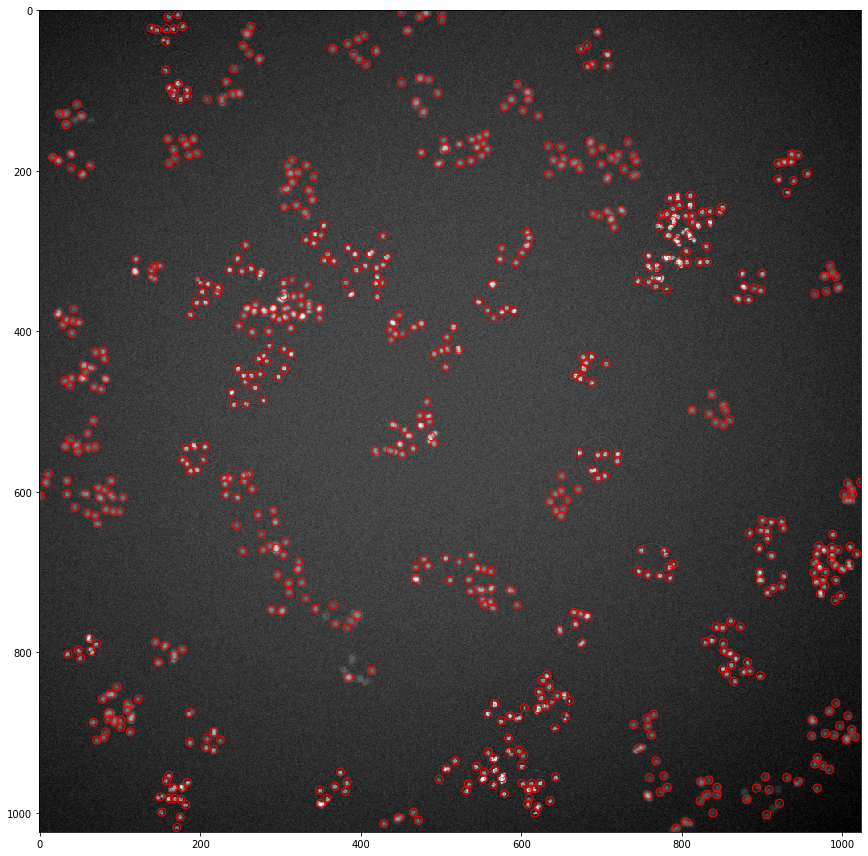

number of spots: 702


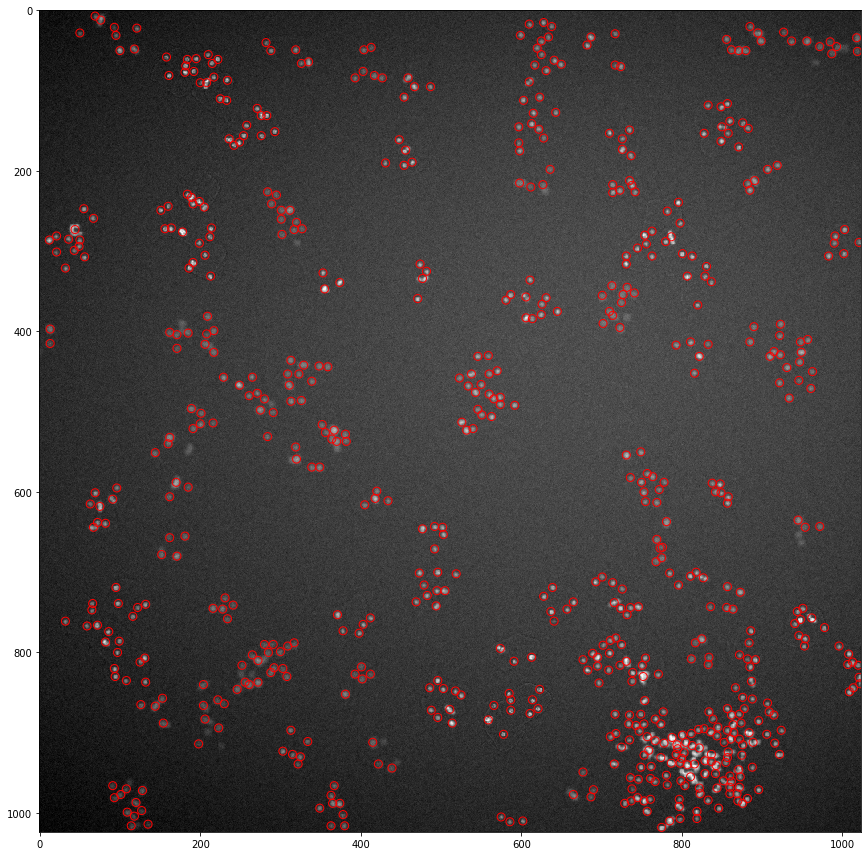

number of spots: 688


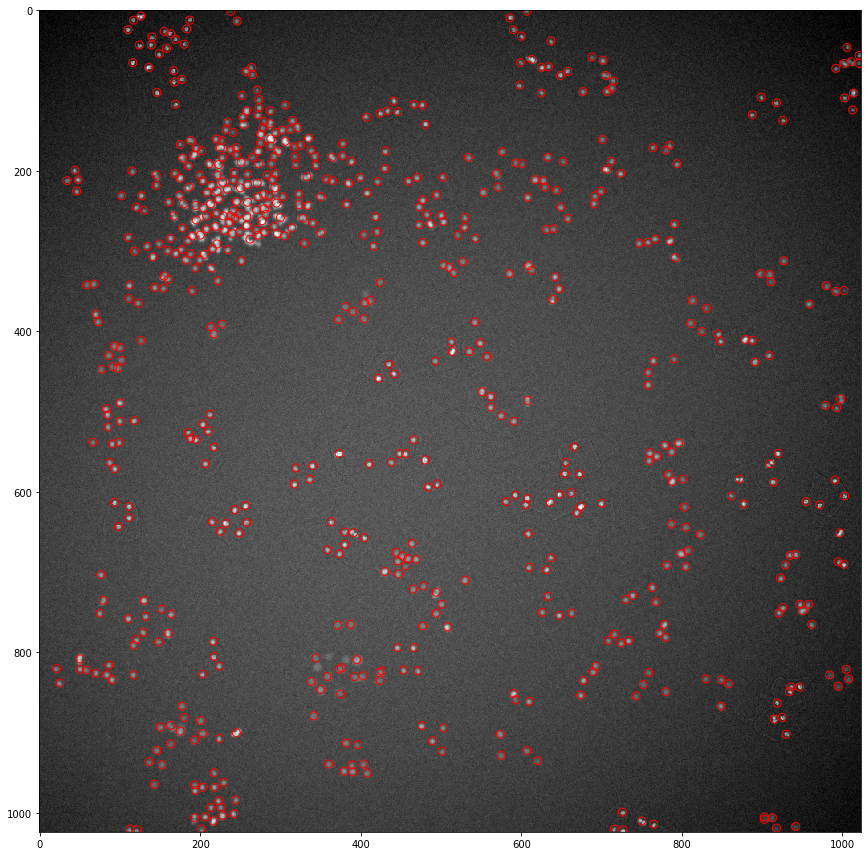

number of spots: 655


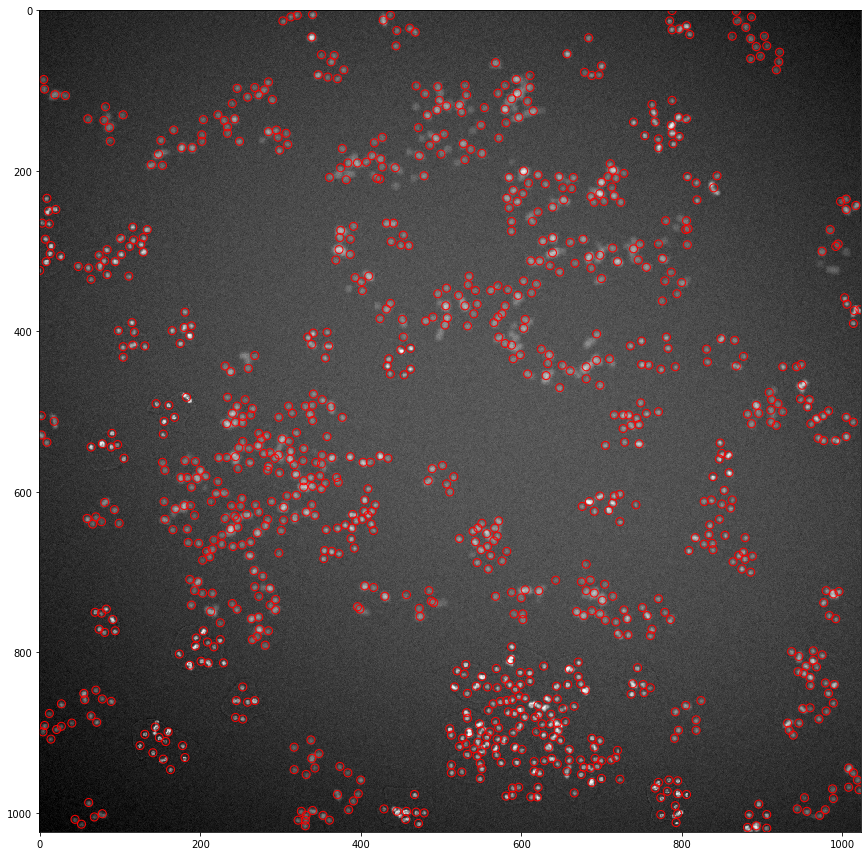

number of spots: 1004


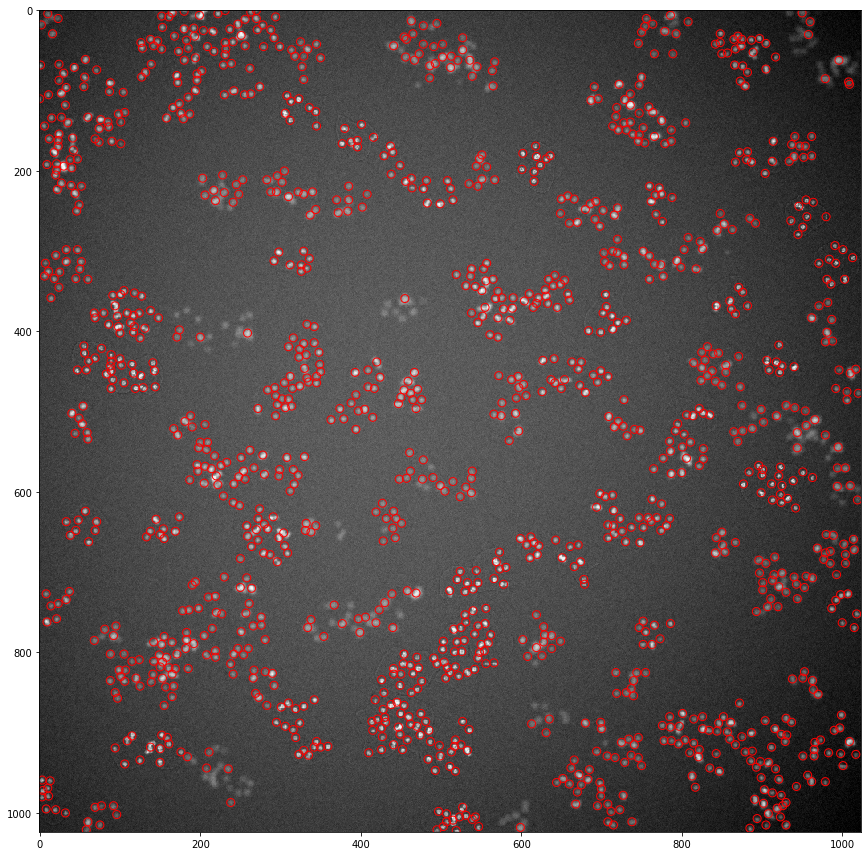

number of spots: 1334


In [9]:
for path in paths_sources:
    fig, ax = plt.subplots(figsize=(20, 12))
    pointImage = tifffile.imread(path)
    label_image = label(pointImage)
    image_label_overlay = label2rgb(label_image, image=sources[index])
    ax.imshow(sources[index], cmap="gray")
    spotCount = 0
    for region in regionprops(label_image):
        (x,y) = region.centroid
        radius = region.equivalent_diameter/2.0
        rect = mpatches.Circle((y,x), 5, fill=False, edgecolor='red')
        ax.add_patch(rect)
        spotCount = spotCount + 1
    nrOfSpots.append(spotCount)
        
    index = index + 1
    plt.tight_layout()
    plt.show()
    print("number of spots: " + str(spotCount))

Finally we display the number of spots for each image:

In [10]:
import statistics
index = 0
for path in in_paths_sources:
    print(path + "\t" + str(nrOfSpots[index]))
    index = index + 1
    
print("Mean" + "\t" + str(statistics.mean(nrOfSpots)))
print("StdDev" + "\t" + str(statistics.stdev(nrOfSpots)))

/home/jovyan/data/in/Img_0004_Spt.tif	702
/home/jovyan/data/in/Img_0002_Spt.tif	688
/home/jovyan/data/in/Img_0003_Spt.tif	655
/home/jovyan/data/in/Img_0005_Spt.tif	1004
/home/jovyan/data/in/Img_0001_Spt.tif	1334
Mean	876.6
StdDev	291.80781346632926


And we calculate and display a boxplot of the distribution of the number of cells per image.

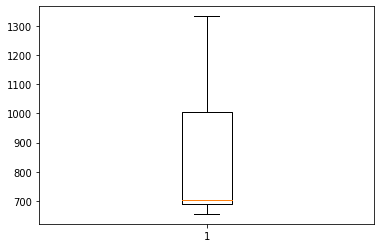

In [11]:
plt.boxplot(nrOfSpots)
plt.show()

## Summary of the metrics

We have the relative error of the spot count per image.

In [12]:
import pprint
pprint.pprint(relativeError)


{'Img_0001_Spt.tif': 0.32249873031995935,
 'Img_0002_Spt.tif': 0.26652452025586354,
 'Img_0003_Spt.tif': 0.23391812865497075,
 'Img_0004_Spt.tif': 0.25,
 'Img_0005_Spt.tif': 0.31654186521443156}


We calculate the mean and standard-deviation.

In [13]:
import statistics
print("Relative Error")
print("Mean:" + "\t" + str(statistics.mean(relativeError.values())))
print("StdDev:" + "\t" + str(statistics.stdev(relativeError.values())))

Relative Error
Mean:	0.27789664888904503
StdDev:	0.03976322730762997


And display a boxplot of the distribution.

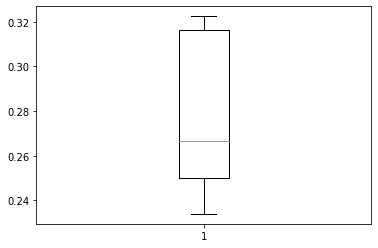

In [15]:
import matplotlib.pyplot as plt
plt.boxplot(relativeError.values());